# Linear Mixed Model Examples

In this tutorial we look at the effects of population structure when undertaking genome-wide association testing and introduce the use of linear mixed models to control for population structure.

## Setting up

In [1]:
# Activate inline plotting
%matplotlib inline
from setup import *

In [2]:
# Import data
# The data used in this study have been pre-converted into an hdf5 file. 
file_name = tutorial_data.get_file('arab107')
geno_reader  = gr.genotype_reader_tables(file_name)
pheno_reader = phr.pheno_reader_tables(file_name)
# The data object allows to query specific genotype or phenotype data
dataset = data.QTLData(geno_reader=geno_reader,pheno_reader=pheno_reader)

#### Load flowering phenotype

In [3]:
phenotype_names = ['5_FT10','6_FT16','7_FT22']
phenotype_query = "(phenotype_ID in %s)" %  str(phenotype_names)

data_subsample_pheno = dataset.subsample_phenotypes(phenotype_query=phenotype_query,
                                                    intersection=True)

#### Subsample genotype for speed

In [4]:
Is = sp.arange(dataset.geno_pos.shape[0])
# Take every 50th SNP, feel free to play around with this number
Is = Is[::50]
data_subsample = data_subsample_pheno.subsample(cols_geno = Is)

#### Get phenotypes

In [5]:
phenotypes,sample_idx = data_subsample.getPhenotypes(phenotype_query=phenotype_query,
                                                     intersection=True) 
phenotype_std = preprocess.rankStandardizeNormal(phenotypes.values)

/Users/davis/anaconda/envs/py2.7/lib/python2.7/site-packages/limix/io/phenotype_reader.py:133: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 199 but corresponding boolean dimension is 192
  phenotypes = pd.DataFrame(data=phenotypes, index=self.sample_ID[sample_idx_intersect],columns=self.phenotype_ID[I])


In [6]:
phenotypes.values

array([[ -3.79256700e-01,  -3.64745160e-01,  -4.43622161e-01],
       [ -2.09255253e-01,  -5.87151005e-01,  -7.08492886e-01],
       [  1.94409641e+00,   2.13114265e+00,   2.44207468e+00],
       [  6.40751981e-01,   8.95554625e-01,   5.32217352e-01],
       [  4.14083385e-01,   6.73148781e-01,   1.69762676e-01],
       [ -4.35923849e-01,  -7.35421567e-01,  -6.38790063e-01],
       [  1.49075922e+00,   2.69951314e+00,   2.44207468e+00],
       [  1.66076066e+00,   2.10643089e+00,   2.44207468e+00],
       [  1.83076211e+00,   3.36673067e+00,   2.44207468e+00],
       [  1.54742636e+00,   7.96707583e-01,   6.71622997e-01],
       [ -4.35923849e-01,  -5.87151005e-01,  -6.38790063e-01],
       [ -6.62592445e-01,  -5.37727484e-01,  -4.99384419e-01],
       [ -9.59209552e-02,  -1.67051076e-01,  -9.51080489e-02],
       [ -1.28593108e+00,  -9.57827412e-01,  -6.94552321e-01],
       [ -5.49258147e-01,  -7.60133328e-01,  -6.94552321e-01],
       [  1.49075922e+00,   2.62537786e+00,   2.4420746

Create histograms to display the distributions of the raw and standardised phenotype values.

(array([  4.,   7.,  18.,  41.,  39.,  37.,  25.,  13.,   6.,   2.]),
 array([-2.41755902, -1.89641731, -1.3752756 , -0.85413389, -0.33299218,
         0.18814952,  0.70929123,  1.23043294,  1.75157465,  2.27271636,
         2.79385806]),
 <a list of 10 Patch objects>)

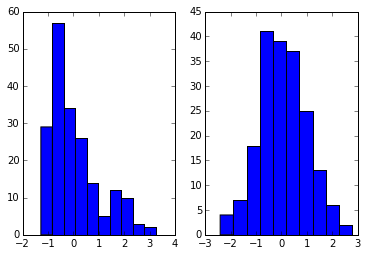

In [7]:
pl.subplot(1,2,1)
pl.hist(phenotypes.values[:,0],10)
pl.subplot(1,2,2)
pl.hist(phenotype_std[:,0],10)

#### Get SNPs and positions

In [8]:
snps = data_subsample.getGenotypes(center=False,unit=False)
position = data_subsample.getPos()
position,chromBounds = data_util.estCumPos(position=position,offset=100000)

In [9]:
N = snps.shape[0]
S = snps.shape[1]
P = phenotypes.shape[1]
print "loaded %d samples, %d phenotypes, %s snps" % (N,P,S)

loaded 192 samples, 3 phenotypes, 4292 snps


# Standard linear regression

Here we look at genome-wide association results when using standard linear regression.

In [10]:
# Run linear regression
covs = None                 #covariates
searchDelta = False         #specify if delta should be optimized for each SNP
test = "lrt"                #specify type of statistical test

# Running the analysis
# When cov are not set (None), LIMIX considers an intercept (covs=SP.ones((N,1)))

lm = qtl.test_lm(snps=snps,pheno=phenotype_std,
                   covs=covs, test=test)

pvalues_lm = lm.getPv()

We can view results using the well-known "Manhattan" plots that plot -log10(p-values) against each variant's location in the genome.

/Users/davis/anaconda/envs/py2.7/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


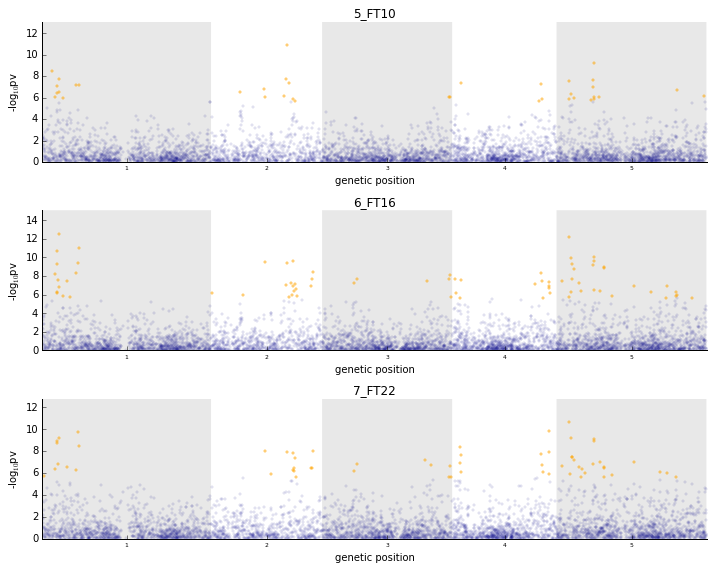

In [11]:
# Genome-wide manhatton plots for one phenotype:
pl.figure(1,figsize=(10,8))
for ip in range(0,3):
    pl.subplot(3,1,ip+1)
    pl.title(phenotype_names[ip])
    plot_manhattan(position['pos_cum'],pvalues_lm[ip,:],chromBounds)
pl.tight_layout()

Quantile-quantile (QQ) plots compare the expected and observed distribtions of p-values. They are very useful as a diagnostic.

/Users/davis/anaconda/envs/py2.7/lib/python2.7/site-packages/matplotlib/axes/_subplots.py:69: MatplotlibDeprecationWarning: The use of 0 (which ends up being the _last_ sub-plot) is deprecated in 1.4 and will raise an error in 1.5
  mplDeprecation)


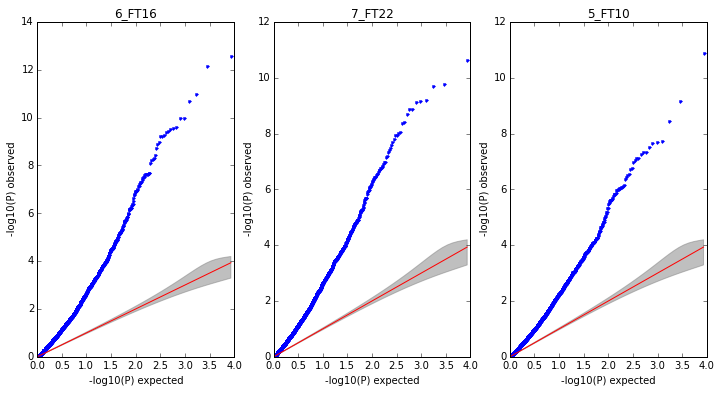

In [12]:
# The formal test QQ-plots
pl.figure(figsize=[12,6])
for ip in xrange(len(phenotype_names)):
    plt = pl.subplot(1,3,ip)
    qqplot(pvalues_lm[ip])
    pl.title(phenotype_names[ip])

# Correcting for Population Structure using PCs

Probably the simplest approach to correcting for population structure is to compute principal components (PCs) of the genotype matrix and include these as covariates in the linear regression model.

#### Computing PCs from genotype data

In [14]:
import sklearn.decomposition.pca as pca
pc = pca.PCA()
pc_snps = pc.fit_transform(snps)

#### Plot PC1 vs PC2

Often the first two PCs will capture population structure effects.

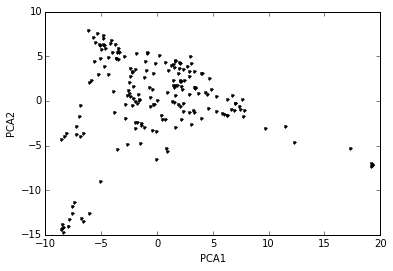

In [15]:
pl.plot(pc_snps[:,0],pc_snps[:,1],'k.')
pl.xlabel('PCA1')
pl.ylabel('PCA2')

#### Plot the proportion of variance explained by each PC:

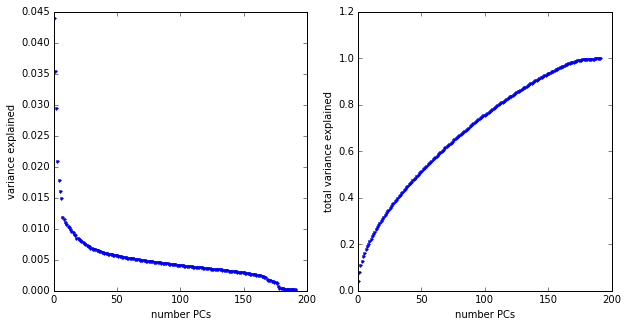

In [16]:
pl.figure(figsize=(10,5))
pl.subplot(1,2,1)
pl.plot(pc.explained_variance_ratio_,".")
pl.xlabel("number PCs")
pl.ylabel("variance explained")

pl.subplot(1,2,2)
pl.plot(pc.explained_variance_ratio_.cumsum(),".")
pl.xlabel("number PCs")
pl.ylabel("total variance explained")

#### Run linear model correcting for population structure as PCs and view QQ plots

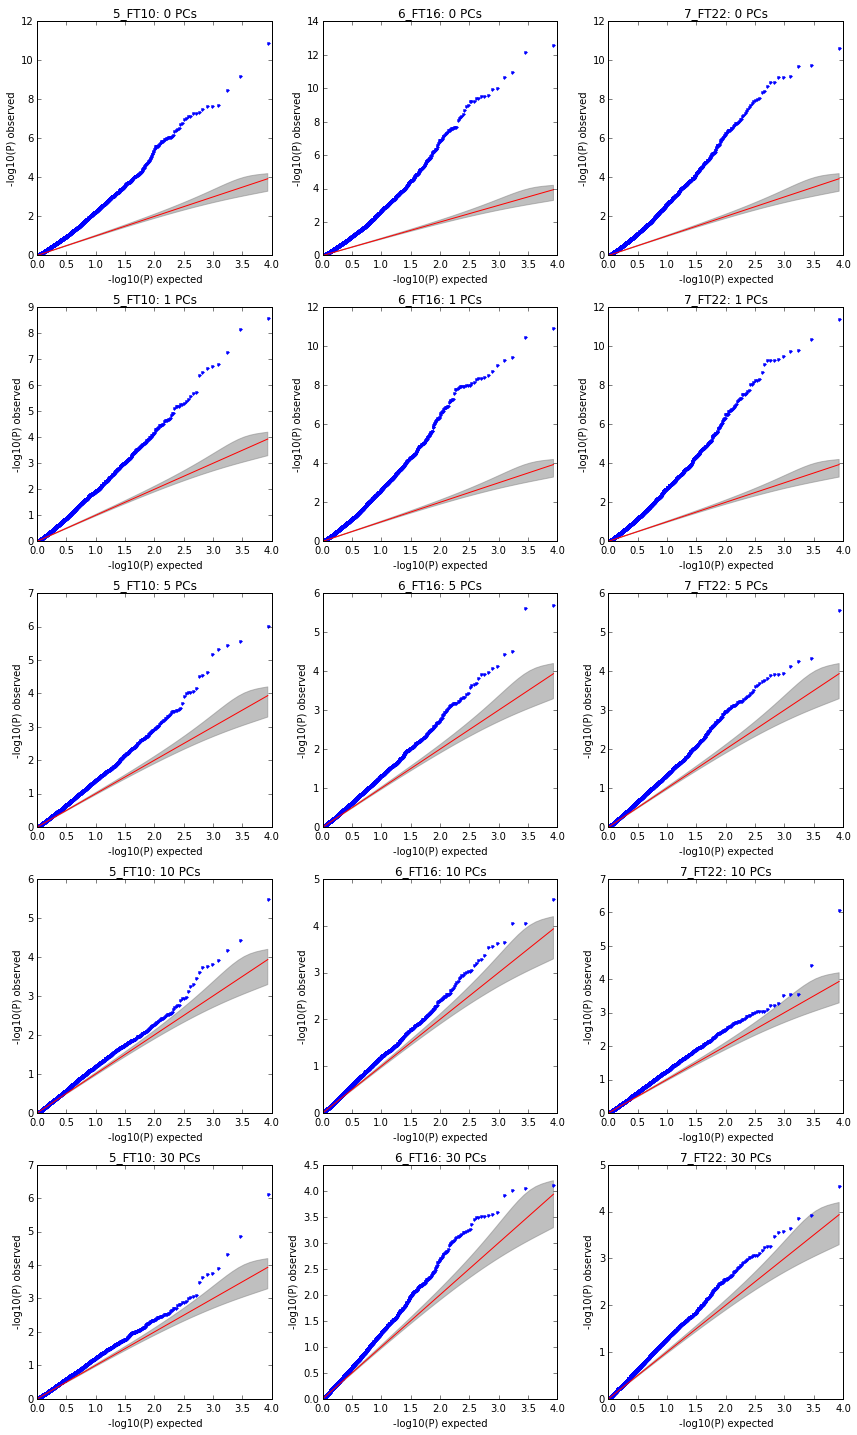

In [17]:
covs_with_pcs = sp.concatenate([sp.ones([snps.shape[0],1]),pc_snps],axis=1)

n_components = [0,1,5,10,30]

pl.figure(figsize=[12,20])
ip = 1
for i in n_components:
    _covs = covs_with_pcs[:,0:i+1]
    # Run a linear model with increasing numbers of PCs
    lm = qtl.test_lm(snps=snps,pheno=phenotype_std,covs=_covs, test=test)
    pvalues_lm = lm.getPv()
    # The following code is for plotting
    for p_id in range(len(phenotype_names)):
        plt = pl.subplot(len(n_components),len(phenotype_names),ip)
        qqplot(pvalues_lm[p_id]) 
        ip+=1
        pl.title('%s: %d PCs' % (phenotype_names[p_id],i))
        
pl.tight_layout()



# Linear mixed models

Linear mixed models (LMMs) add a random effect to the standard linear regression model. The covariance structure for the random effect is defined by the genotypic "relatedness" between samples. Thus, the LMM can correct for population structure effects.

#### Get and plot the relatedness matrix

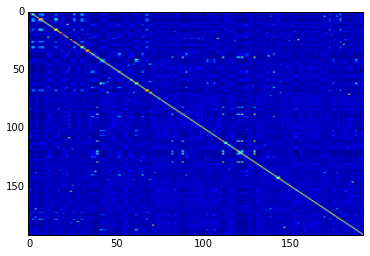

In [18]:
sample_relatedness_unnormalized = data_subsample.getCovariance(normalize=True,center=True)

sample_relatedness  = sample_relatedness_unnormalized/ \
    sample_relatedness_unnormalized.diagonal().mean()
    
pl.imshow(sample_relatedness,aspect='auto')

#### Cluster the relatedness matrix to show structure

<matplotlib.colorbar.Colorbar instance at 0x110336368>

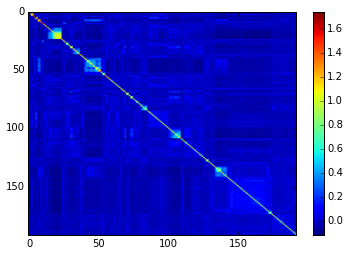

In [19]:
import scipy.cluster.hierarchy as hier
import scipy.spatial.distance as dist
linkageMatrix = hier.linkage(sample_relatedness)
dendro = hier.dendrogram(linkageMatrix, no_plot=True)
pl.clf()
leaves = dendro['leaves']
pl.imshow(sample_relatedness[leaves,:][:,leaves],aspect='auto')
pl.colorbar()

#### Run linear mixed model

In [20]:
# Run a linear mixed model and a standard lmm for comparison
covs = None                 #covariates
searchDelta = False         #specify if delta should be optimized for each SNP
test="lrt"                  #specify type of statistical test

lm = qtl.test_lm(snps=snps,pheno=phenotype_std,
                   covs=covs, test=test)
pvalues_lm = lm.getPv()       # 1xS vector of p-values (S=X.shape[1])#convert P-values to a DataFrame for nice output writing:
pvalues_lm = pd.DataFrame(data=pvalues_lm.T,index=data_subsample.geno_ID,
                       columns=phenotypes.columns)

lmm = qtl.test_lmm(snps=snps,pheno=phenotype_std,
                   K=sample_relatedness,covs=covs, test=test)

pvalues_lmm = lmm.getPv()       # 1xS vector of p-values (S=X.shape[1])#convert P-values to a DataFrame for nice output writing:
pvalues_lmm = pd.DataFrame(data=pvalues_lmm.T,index=data_subsample.geno_ID,
                       columns=phenotypes.columns)

Produce Manhattan plots to show the results.

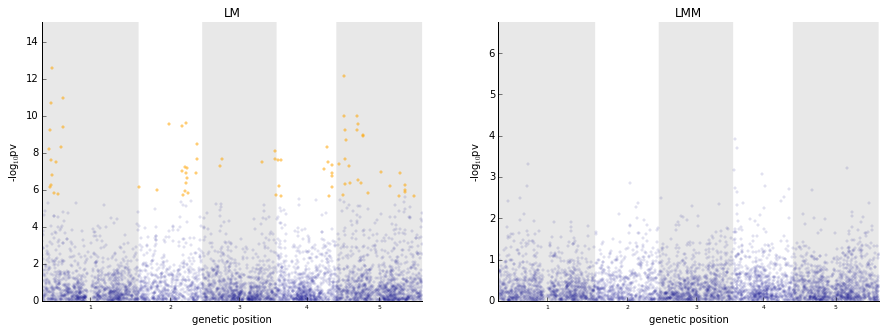

In [21]:
pl.figure(figsize=[15,5])
plt = pl.subplot(1,2,1)
plot_manhattan(position['pos_cum'],pvalues_lm[phenotype_names[1]].values,chromBounds)
pl.title('LM')
plt = pl.subplot(1,2,2)
plot_manhattan(position['pos_cum'],pvalues_lmm[phenotype_names[1]].values,chromBounds)
pl.title('LMM')



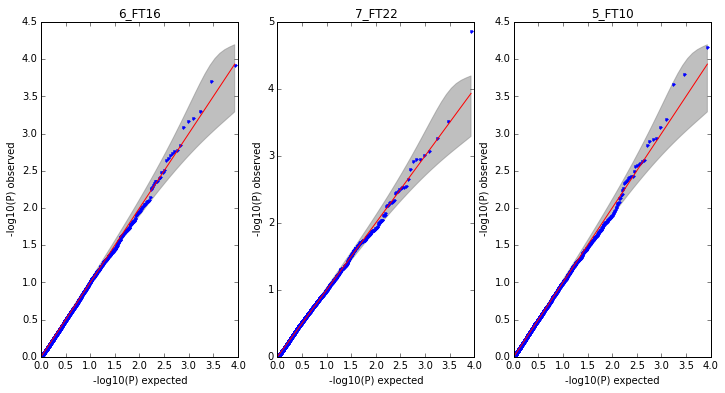

In [22]:
# The formal test QQ-plots
pl.figure(figsize=[12,6])
for ip in xrange(len(phenotype_names)):
    plt = pl.subplot(1,3,ip)
    qqplot(pvalues_lmm[phenotype_names[ip]].values)
    pl.title(phenotype_names[ip])

## Questions

* What do you conclude about the effects of population structure on genome-wide testing?
* What is the effect of using a linear mixed model instead of a standard regression model on this data?
* What should be the preferred approach for eQTL mapping?
